# Example 07: Uncertainty in gas properties calculated from measured speed of sound

This notebook demonstrates uncertainty calculations for gas properties (density and molar mass) derived from measured speed of sound.
The calculation uses the GERG-2008 equation of state to calculate the isentropic exponent (kappa) and compressibility factor (Z),
which are then used together with the measured speed of sound to calculate density and molar mass.

Uncertainty evaluations are performed using standard uncertainty calculations based on sensitivity coefficients and input uncertainties.

In [1]:
# Import Required Libraries
import pvtlib
from uncertaintylib import uncertainty_functions, plot_functions
import pandas as pd
import os

### Read inputs from CSV file

The inputs to the uncertainty calculation are provided in a CSV file.

The input contains:
- Pressure (P) - bara
- Temperature (T) - °C
- Measured speed of sound (measured_sos)
- Gas composition (N2, CO2, C1, C2, C3, iC4, nC4)
- GERG model uncertainty factors for kappa and Z

Key features:
- Uncertainty can be provided either as an absolute value (standard_uncertainty) or as a percentage (standard_uncertainty_percent)
- If both are given, the code will use the larger of the two
- Distribution, min and max are used by Monte Carlo simulations
- Unit is for information only
- The GERG uncertainty factors (mean value = 1.0, uncertainty = 0.05%) account for model uncertainty in the equation of state

In [2]:
notebook_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
data_path = os.path.join(notebook_dir, 'data.csv')
df = pd.read_csv(data_path)

df  # Display the dataframe

,input_name,unit,mean,standard_uncertainty,standard_uncertainty_percent,distribution,min,max
0,P,bara,100.00,0.1500,NaN,normal,NaN,NaN
1,T,C,50.00,0.1500,NaN,normal,NaN,NaN
2,measured_sos,m/s,433.00,NaN,0.10,normal,NaN,NaN
3,N2,mol%,1.00,0.0344,NaN,normal,0.0,100.0
4,CO2,mol%,2.00,0.0191,NaN,normal,0.0,100.0
5,C1,mol%,90.00,0.0000,NaN,normal,0.0,100.0
6,C2,mol%,6.40,0.0329,NaN,normal,0.0,100.0
7,C3,mol%,0.50,0.0126,NaN,normal,0.0,100.0
8,iC4,mol%,0.05,0.0026,NaN,normal,0.0,100.0
9,nC4,mol%,0.05,0.0025,NaN,normal,0.0,100.0


### Convert dataframe to dictionary

Input to uncertaintylib must be a dictionary. Convert the dataframe to a dictionary.

In [3]:
df = df.set_index('input_name')

inputs = df.to_dict()  # Convert dataframe to dictionary, which is the required format for uncertaintylib

### Define the function to calculate gas properties from measured speed of sound

This function:
1. Calculates gas properties using GERG-2008 equation of state from composition, P, and T
2. Applies model uncertainty factors to kappa and Z to account for GERG-2008 model uncertainty
3. Uses the calculated kappa and Z values (with model uncertainty) along with measured speed of sound to determine:
   - Molar mass from speed of sound
   - Density from speed of sound

The GERG uncertainty factors have a mean value of 1.0 and a standard deviation of 0.05%, allowing the uncertainty analysis to account for inherent limitations in the equation of state model.

In [4]:
def calculate_properties_from_sos(inarray):
    """
    Function to calculate gas density and molar mass from measured speed of sound.
    
    Parameters:
    -----------
    inarray : dict
        Dictionary with all input parameters including pressure, temperature,
        measured speed of sound, and gas composition.
    
    Returns:
    --------
    outarray : dict
        Dictionary with calculated output parameters:
        - molar_mass_from_sos: Molar mass calculated from speed of sound [kg/kmol]
        - density_from_sos: Density calculated from speed of sound [kg/m3]
        - kappa: Isentropic exponent from GERG-2008 [-]
        - z: Compressibility factor from GERG-2008 [-]
    """
    
    outarray = {}  # Create an empty dictionary to store output parameters
    
    # Set up AGA8 object for GERG-2008 equation of state
    gerg = pvtlib.AGA8('GERG-2008')
    
    # Build composition dictionary from input array
    composition = {
        'N2': inarray['N2'],
        'CO2': inarray['CO2'],
        'C1': inarray['C1'],
        'C2': inarray['C2'],
        'C3': inarray['C3'],
        'iC4': inarray['iC4'],
        'nC4': inarray['nC4'],
    }
    
    # Step 1: Calculate properties using composition, P, and T
    gerg_properties = gerg.calculate_from_PT(
        composition=composition,
        pressure=inarray['P'],
        temperature=inarray['T'],
        pressure_unit='bara',
        temperature_unit='C',
    )
    
    # Store GERG-calculated properties (multiplied by uncertainty factors to account for model uncertainty)
    outarray['kappa'] = gerg_properties['kappa'] * inarray['GERG_kappa_uncertainty_factor']
    outarray['z'] = gerg_properties['z'] * inarray['GERG_Z_uncertainty_factor']
    
    # Step 2: Calculate molar mass from measured speed of sound
    # Using kappa and Z with model uncertainty factors applied
    outarray['molar_mass_from_sos'] = pvtlib.thermodynamics.molar_mass_from_sos_kappa(
        measured_sos=inarray['measured_sos'],
        kappa=outarray['kappa'],
        Z=outarray['z'],
        temperature_C=inarray['T']
    )
    
    # Step 3: Calculate density from measured speed of sound
    # Using kappa with model uncertainty factor applied
    outarray['density_from_sos'] = pvtlib.thermodynamics.density_from_sos_kappa(
        measured_sos=inarray['measured_sos'],
        kappa=outarray['kappa'],
        pressure_bara=inarray['P']
    )
    
    return outarray

### Calculate uncertainty using sensitivity coefficients and input uncertainties

Uncertainty is calculated using the function `calculate_uncertainty`, which returns a dictionary with the following results:

| Key         | Description                                                                                   |
|-------------|-----------------------------------------------------------------------------------------------|
| `value`     | The actual output values returned from the function (based on the 'mean' input values)        |
| `variance`  | The variance for each input parameter for each output parameter                               |
| `contribution` | The percentage contribution of each input variable to the uncertainty in each output variable |
| `u`         | Combined Standard Uncertainty (u) for each output parameter                                   |
| `U`         | Expanded Uncertainty (95% confidence level, k=2) for each output parameter                    |
| `U_perc`    | Relative Expanded Uncertainty (95% confidence level, k=2) for each output parameter, in %     |

This allows you to see both the calculated values and the detailed breakdown of uncertainty contributions for each output variable.

In [5]:
uncertainty_results = uncertainty_functions.calculate_uncertainty(
    indata=inputs,
    function=calculate_properties_from_sos
)

### Print calculated properties including uncertainties

In [6]:
print('\n--- Gas Properties Calculated from Measured Speed of Sound ---')
print(f"Density from SOS: {uncertainty_results['value']['density_from_sos']:.3f} kg/m3 ± {uncertainty_results['U_perc']['density_from_sos']:.3f} % (k=2)")
print(f"Molar Mass from SOS: {uncertainty_results['value']['molar_mass_from_sos']:.3f} kg/kmol ± {uncertainty_results['U_perc']['molar_mass_from_sos']:.3f} % (k=2)")

print('\n--- Intermediate Properties from GERG-2008 (with model uncertainty) ---')
print(f"Isentropic Exponent (kappa): {uncertainty_results['value']['kappa']:.4f} ± {uncertainty_results['U_perc']['kappa']:.3f} % (k=2)")
print(f"Compressibility Factor (Z): {uncertainty_results['value']['z']:.4f} ± {uncertainty_results['U_perc']['z']:.3f} % (k=2)")


--- Gas Properties Calculated from Measured Speed of Sound ---
Density from SOS: 76.361 kg/m3 ± 0.551 % (k=2)
Molar Mass from SOS: 17.891 kg/kmol ± 0.439 % (k=2)

--- Intermediate Properties from GERG-2008 (with model uncertainty) ---
Isentropic Exponent (kappa): 1.4317 ± 0.127 % (k=2)
Compressibility Factor (Z): 0.8720 ± 0.125 % (k=2)


### Plot contributions to uncertainty in Density from Speed of Sound

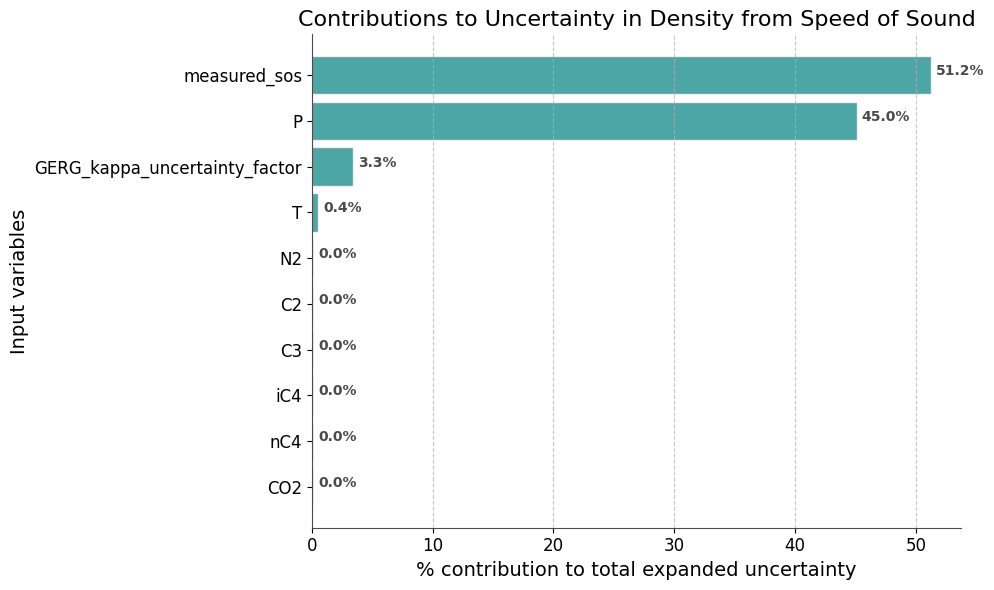

In [7]:
fig1 = plot_functions.plot_uncertainty_contribution(
    res=uncertainty_results,
    property_id='density_from_sos',
    plot_title='Contributions to Uncertainty in Density from Speed of Sound',
    filter_top_x=10
)

### Plot contributions to uncertainty in Molar Mass from Speed of Sound

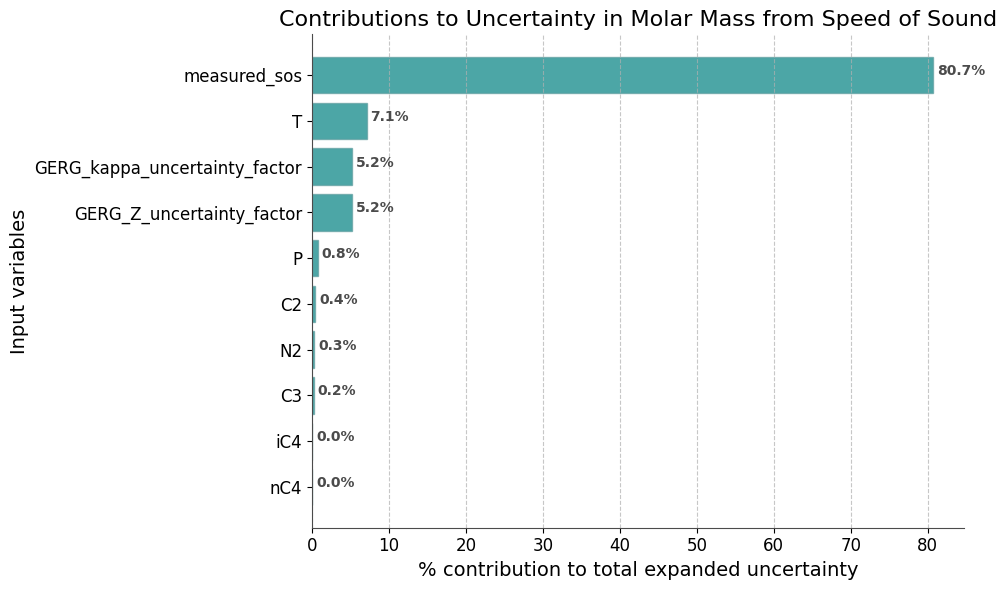

In [8]:
fig2 = plot_functions.plot_uncertainty_contribution(
    res=uncertainty_results,
    property_id='molar_mass_from_sos',
    plot_title='Contributions to Uncertainty in Molar Mass from Speed of Sound',
    filter_top_x=10
)

### Display detailed uncertainty contributions

Show the contribution of each input parameter to the uncertainty in density and molar mass.

In [9]:
# Create a dataframe showing contributions for density
print('\n=== Detailed Uncertainty Contributions for Density from SOS ===')
contribution_df_density = pd.DataFrame({
    'Input Parameter': list(uncertainty_results['contribution']['density_from_sos'].keys()),
    'Contribution (%)': list(uncertainty_results['contribution']['density_from_sos'].values())
})
contribution_df_density = contribution_df_density.sort_values('Contribution (%)', ascending=False)
print(contribution_df_density.to_string(index=False))

# Create a dataframe showing contributions for molar mass
print('\n=== Detailed Uncertainty Contributions for Molar Mass from SOS ===')
contribution_df_mm = pd.DataFrame({
    'Input Parameter': list(uncertainty_results['contribution']['molar_mass_from_sos'].keys()),
    'Contribution (%)': list(uncertainty_results['contribution']['molar_mass_from_sos'].values())
})
contribution_df_mm = contribution_df_mm.sort_values('Contribution (%)', ascending=False)
print(contribution_df_mm.to_string(index=False))


=== Detailed Uncertainty Contributions for Density from SOS ===
              Input Parameter  Contribution (%)
                 measured_sos         51.197945
                            P         45.023391
GERG_kappa_uncertainty_factor          3.296749
                            T          0.440560
                           N2          0.014386
                           C2          0.012315
                           C3          0.011849
                          iC4          0.001464
                          nC4          0.001325
                          CO2          0.000016
                           C1          0.000000
    GERG_Z_uncertainty_factor          0.000000

=== Detailed Uncertainty Contributions for Molar Mass from SOS ===
              Input Parameter  Contribution (%)
                 measured_sos         80.681619
                            T          7.121728
    GERG_Z_uncertainty_factor          5.195268
GERG_kappa_uncertainty_factor          5.195268
   

## Run Monte Carlo simulation

Uncertainties can also be determined using the Monte Carlo method. In this method, uncertainty distributions for each input variable are generated randomly, and then the outputs are calculated from these input distributions. The standard deviation of the resulting output distribution reflects the uncertainty of that output parameter.

The Monte Carlo method is particularly useful for:
- Validating analytical uncertainty calculations
- Handling non-linear relationships
- Understanding the full probability distribution of outputs

In [10]:
monte_carlo_results = uncertainty_functions.monte_carlo_simulation(
    mc_input=inputs,
    function=calculate_properties_from_sos,
    n=10000
)

# The monte_carlo_results is a dataframe with the results of the Monte Carlo simulation
# The 'calculate_monte_carlo_statistics' is used to calculate the mean, standard deviations and relative standard deviations of the results
monte_carlo_statistics = uncertainty_functions.calculate_monte_carlo_statistics(monte_carlo_results)

# Display the Monte Carlo statistics
print(monte_carlo_statistics)

                          mean   std_dev  std_dev_percent  std_dev_k2  \
kappa                 1.431673  0.000913         0.063755    0.001826   
z                     0.871995  0.000545         0.062534    0.001091   
molar_mass_from_sos  17.890438  0.039665         0.221711    0.079330   
density_from_sos     76.358121  0.212073         0.277734    0.424145   

                     std_dev_percent_k2  
kappa                          0.127509  
z                              0.125068  
molar_mass_from_sos            0.443422  
density_from_sos               0.555468  


### Plot the probability distribution for Molar Mass from Speed of Sound

This plot shows the histogram of the Monte Carlo simulation results, displaying the probability distribution of the molar mass calculated from speed of sound.

c:\Appl\GitHub\uncertaintylib\examples\07 - Gas properties from speed of sound (Jupyter)\.venv\Lib\site-packages\uncertaintylib\plot_functions.py:150: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


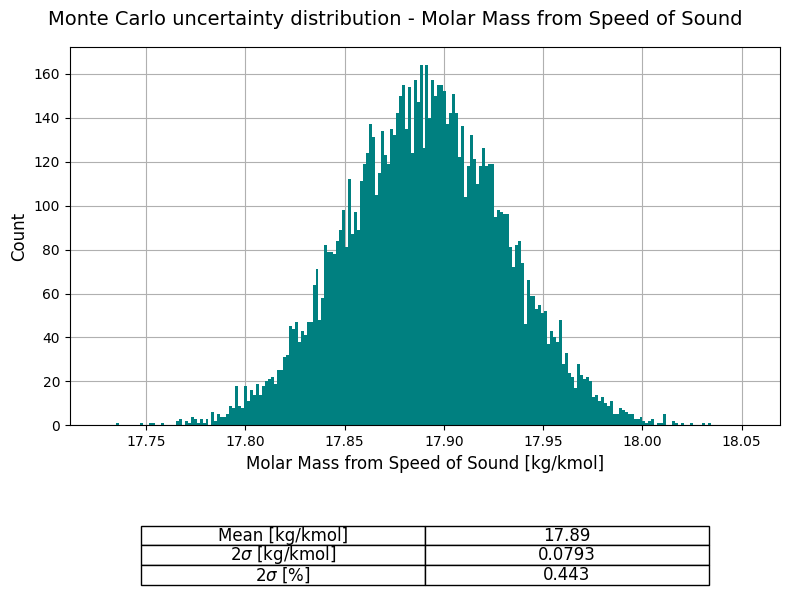

In [11]:
fig4 = plot_functions.montecarlo_property_plot_and_table(
    data=monte_carlo_results,
    property_id='molar_mass_from_sos',
    xlim=[-1, 1],
    property_name='Molar Mass from Speed of Sound',
    property_unit='kg/kmol',
    round_props={'mean': 3, 'std': 4, 'stdperc': 3}
)

### Plot the probability distribution for Density from Speed of Sound

This plot shows the histogram of the Monte Carlo simulation results, displaying the probability distribution of the density calculated from speed of sound.

c:\Appl\GitHub\uncertaintylib\examples\07 - Gas properties from speed of sound (Jupyter)\.venv\Lib\site-packages\uncertaintylib\plot_functions.py:150: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


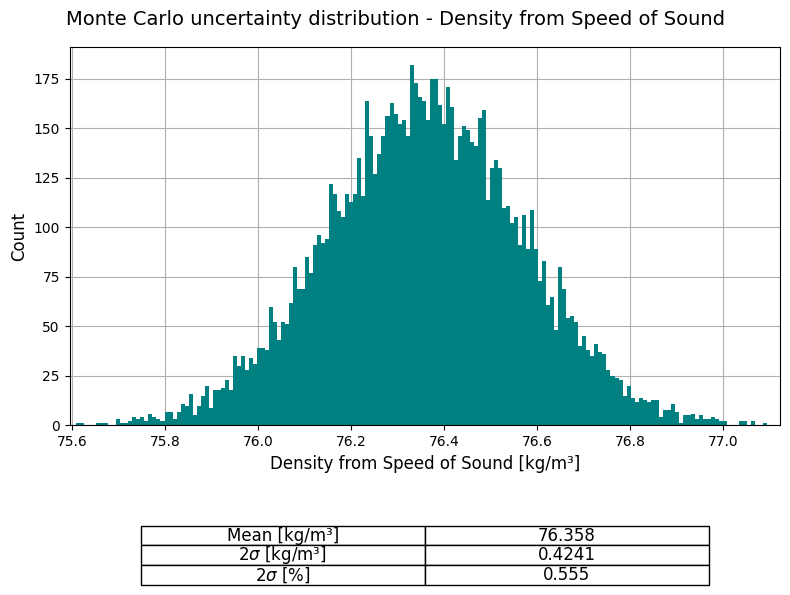

In [12]:
fig3 = plot_functions.montecarlo_property_plot_and_table(
    data=monte_carlo_results,
    property_id='density_from_sos',
    xlim=[-1, 1],
    property_name='Density from Speed of Sound',
    property_unit='kg/m³',
    round_props={'mean': 3, 'std': 4, 'stdperc': 3}
)

### Compare Monte Carlo results with analytical uncertainty calculation

Note that the mean values from the Monte Carlo simulation will not be completely identical to the output values from the function itself (calculated using the mean inputs), due to the random nature of the Monte Carlo simulation. But as the number of perturbations (n) goes towards infinity, the mean values from the Monte Carlo will converge towards the actual output values.

The uncertainty values, however, will be representative and should be very close to those from the analytical uncertainty calculation.

In [13]:
print('\n=== Monte Carlo Results vs Analytical Uncertainty Calculation ===\n')

print('--- Density from Speed of Sound ---')
print(f"Analytical:    {uncertainty_results['value']['density_from_sos']:.3f} kg/m3 ± {uncertainty_results['U_perc']['density_from_sos']:.3f} % (k=2)")
print(f"Monte Carlo:   {monte_carlo_statistics.loc['density_from_sos', 'mean']:.3f} kg/m3 ± {monte_carlo_statistics.loc['density_from_sos', 'std_dev_percent_k2']:.3f} % (k=2)")

print('\n--- Molar Mass from Speed of Sound ---')
print(f"Analytical:    {uncertainty_results['value']['molar_mass_from_sos']:.3f} kg/kmol ± {uncertainty_results['U_perc']['molar_mass_from_sos']:.3f} % (k=2)")
print(f"Monte Carlo:   {monte_carlo_statistics.loc['molar_mass_from_sos', 'mean']:.3f} kg/kmol ± {monte_carlo_statistics.loc['molar_mass_from_sos', 'std_dev_percent_k2']:.3f} % (k=2)")


=== Monte Carlo Results vs Analytical Uncertainty Calculation ===

--- Density from Speed of Sound ---
Analytical:    76.361 kg/m3 ± 0.551 % (k=2)
Monte Carlo:   76.358 kg/m3 ± 0.555 % (k=2)

--- Molar Mass from Speed of Sound ---
Analytical:    17.891 kg/kmol ± 0.439 % (k=2)
Monte Carlo:   17.890 kg/kmol ± 0.443 % (k=2)
